In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_18\Project.toml`


In [2]:
using TrajectoryOptimization
using RobotDynamics
const RD = RobotDynamics
import RobotZoo.Cartpole
using StaticArrays
using SparseArrays
using LinearAlgebra
using ForwardDiff
using Plots
using OSQP

## We're gonna use Cartpole dynamics

In [3]:
model = Cartpole()
n,m = size(model);

In [42]:
N = 101
Tf = 5.
h = Tf/(N-1)

Nt = Int(Tf/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

## Set up for Altro

In [5]:
x0 = @SVector zeros(n)
xf = @SVector [0, pi, 0, 0];  # i.e. swing up

In [6]:
Q = 1.0*Diagonal(@SVector ones(n))
Qf = 100.0*Diagonal(@SVector ones(n))
R = 0.1*Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N);

In [7]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Control Bounds
u_bnd = 5.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, (N-5):N)

In [8]:
prob = Problem(model, obj, x0, Tf, xf=xf, constraints=conSet);

In [9]:
u0 = @SVector fill(0.0,m)
U0 = [u0 for k = 1:N-1]
initial_controls!(prob, U0)
rollout!(prob);

## We'll solve LQR with bound codition using Julia pkg Altro

In [10]:
using Altro

opts = SolverOptions(
    cost_tolerance_intermediate=1e-3,
    penalty_scaling=10.,
    penalty_initial=1.0
)

altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 205
    Solve Time: 1916.3048999999999 (ms)

  Covergence
    Terminal Cost: 928.317996972354
    Terminal dJ: 0.04853163702932761
    Terminal gradient: 9.07219858099095e-6
    Terminal constraint violation: 4.63767647396196e-7
    Solve Status: SOLVE_SUCCEEDED


## Extract Solution

In [11]:
Xopt = states(altro);
Uopt = controls(altro);

# nominal states (trajectory)
xnom = zeros(n, N)
unom = zeros(m, N-1)

# real trajectory (real dynamics), initialize for initial guess
utraj = zeros(m, N-1)
for k in 1:N
    xnom[:,k] .= Xopt[k]
    
    if k != N
        unom[:,k] .= Uopt[k]
        utraj[:,k] .= Uopt[k]
    end
end

## Sim dynamics and True dynamics with RK4 Integration

In [12]:
function dynamics_rk4(x, u)
    #RK4 integration with zero-order hold on u
    f1 = RD.dynamics(model, x, u)
    f2 = RD.dynamics(model, x + 0.5*h*f1, u)
    f3 = RD.dynamics(model, x + 0.5*h*f2, u)
    f4 = RD.dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

#True model with friction
function true_dynamics(model::Cartpole, x, u)
    #Perturb masses of cart + pole
    mc = model.mc + 0.02
    mp = model.mp - 0.01
    
    #Perturb length of pendulum
    l = model.l + 0.005
    g = model.g

    q = x[ @SVector [1,2] ]
    qd = x[ @SVector [3,4] ]

    s = sin(q[2])
    c = cos(q[2])

    H = @SMatrix [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = @SMatrix [0 -mp*qd[2]*l*s; 0 0]
    G = @SVector [0, mp*g*l*s]
    B = @SVector [1, 0]
    
    F = [0.01; 0.01].*tanh.(5.0*qd) #nonlinear friction (≈Coulomb/stiction)

    qdd = -H\(C*qd + F + G - B*u[1])
    return [qd; qdd]
end

function true_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = true_dynamics(model, x, u)
    f2 = true_dynamics(model, x + 0.5*h*f1, u)
    f3 = true_dynamics(model, x + 0.5*h*f2, u)
    f4 = true_dynamics(model, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

true_dynamics_rk4 (generic function with 1 method)

## Compute A and B matrices using nominal dynamics + trajectory

In [13]:
dA = zeros(n, n, N-1)
dB = zeros(n, m, N-1)

for k in 1:(N-1)
    dA[:,:,k] = ForwardDiff.jacobian(_x -> dynamics_rk4(_x, Uopt[k]), Xopt[k])
    dB[:,:,k] = ForwardDiff.jacobian(_u -> dynamics_rk4(Xopt[k], _u), Uopt[k])
end

## Compute LQR Gain P, K 

In [14]:
P = zeros(n, n, N)
K = zeros(m, n, N-1)

P[:,:,end] = Qf
for k in (N-1):-1:1
    K[:,:,k] .= (R + dB[:,:,k]'*P[:,:,k+1]*dB[:,:,k]) \ (dB[:,:,k]'*P[:,:,k+1]*dA[:,:,k])
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (dA[:,:,k]- dB[:,:,k]*K[:,:,k])'*P[:,:,k+1]*(dA[:,:,k]- dB[:,:,k]*K[:,:,k])
end

## Rollout with true dynamics - Open Loop Control

In [15]:
xtraj = zeros(n, N)

for k in 1:(N-1)
    # utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k] - xnom[:,k])
    # utraj[:,k] .= min.(max.(utraj[:,k], -u_bnd), u_bnd)
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end

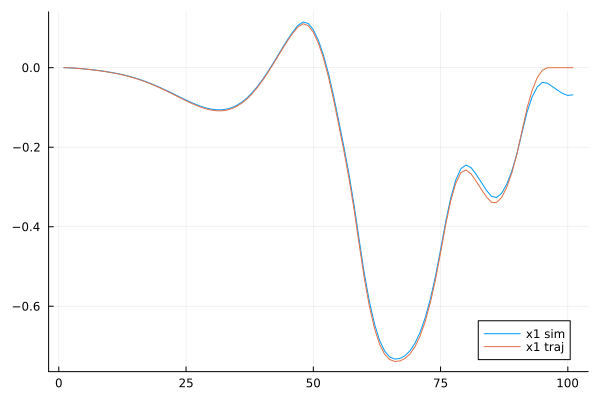

In [16]:
plot(xtraj[1,:], label="x1 sim")
plot!(xnom[1,:], label="x1 traj")

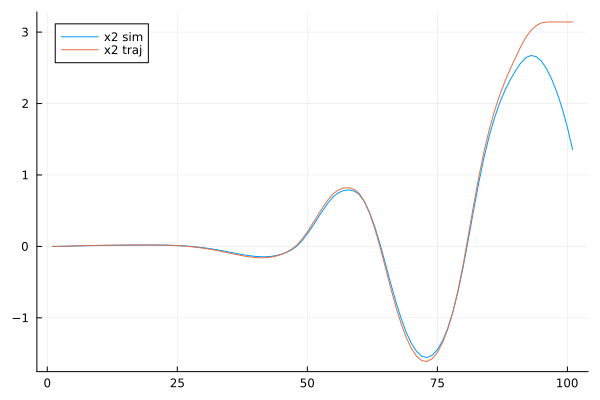

In [17]:
plot(xtraj[2,:], label="x2 sim")
plot!(xnom[2,:], label="x2 traj")

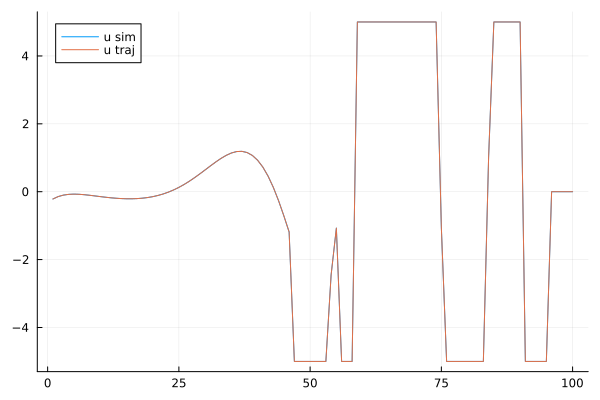

In [18]:
plot(utraj[1,:], label="u sim")
plot!(Uopt[:], label="u traj")

## Rollout with true dynamics - Closed Loop LQR Control 

In [19]:
xtraj = zeros(n, N)
utraj = zeros(m, N-1)
for k in 1:N
    xnom[:,k] .= Xopt[k]
    
    if k != N
        unom[:,k] .= Uopt[k]
        utraj[:,k] .= Uopt[k]
    end
end

for k in 1:(N-1)
    utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k] - xnom[:,k])
    # utraj[:,k] .= min.(max.(utraj[:,k], -u_bnd), u_bnd)
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end

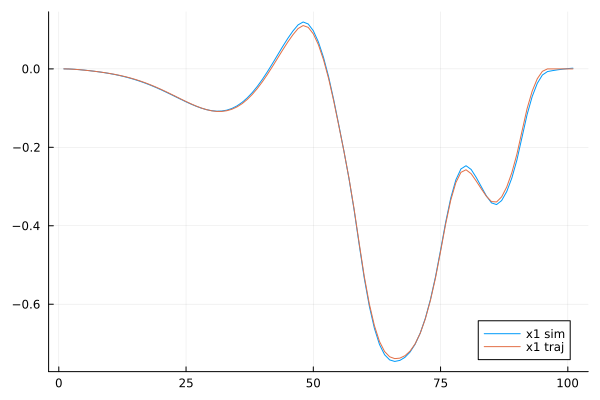

In [20]:
plot(xtraj[1,:], label="x1 sim")
plot!(xnom[1,:], label="x1 traj")

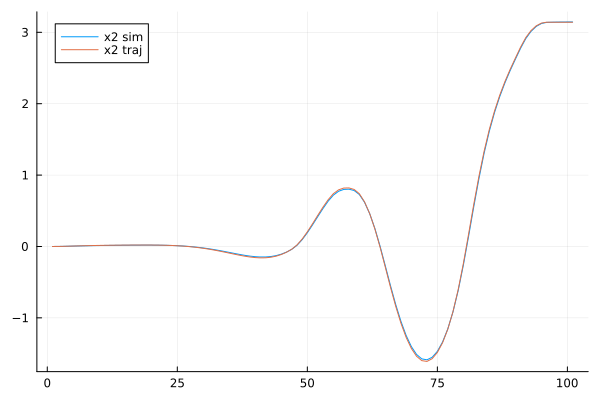

In [21]:
plot(xtraj[2,:], label="x2 sim")
plot!(xnom[2,:], label="x2 traj")

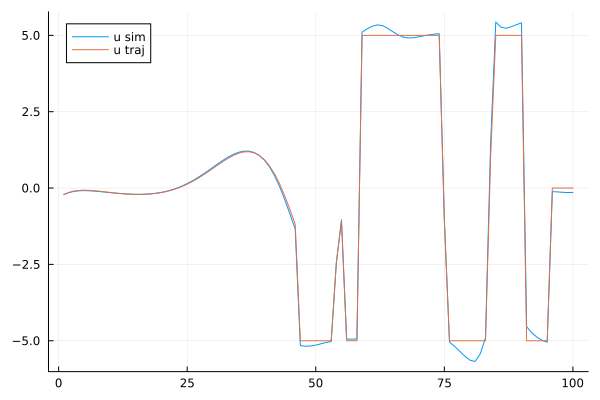

In [22]:
plot(utraj[1,:], label="u sim")
plot!(Uopt[:], label="u traj")

## Rollout with true dynamics - Closed Loop LQR Control + Control Limit

In [23]:
xtraj = zeros(n, N)
utraj = zeros(m, N-1)
for k in 1:N
    xnom[:,k] .= Xopt[k]
    
    if k != N
        unom[:,k] .= Uopt[k]
        utraj[:,k] .= Uopt[k]
    end
end

for k in 1:(N-1)
    utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k] - xnom[:,k])
    utraj[:,k] .= min.(max.(utraj[:,k], -u_bnd), u_bnd)
    xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
end

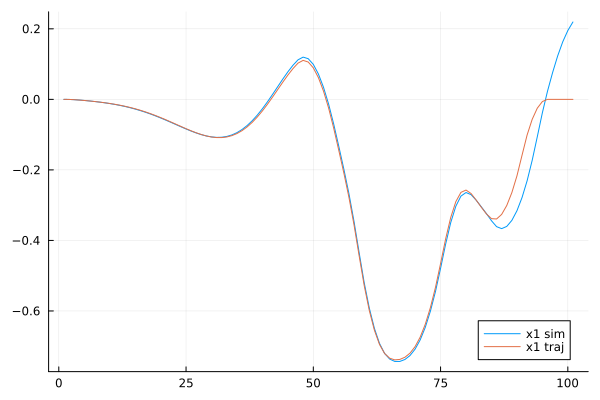

In [24]:
plot(xtraj[1,:], label="x1 sim")
plot!(xnom[1,:], label="x1 traj")

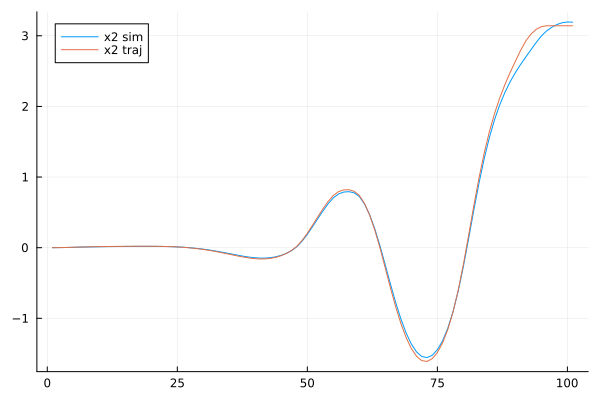

In [25]:
plot(xtraj[2,:], label="x2 sim")
plot!(xnom[2,:], label="x2 traj")

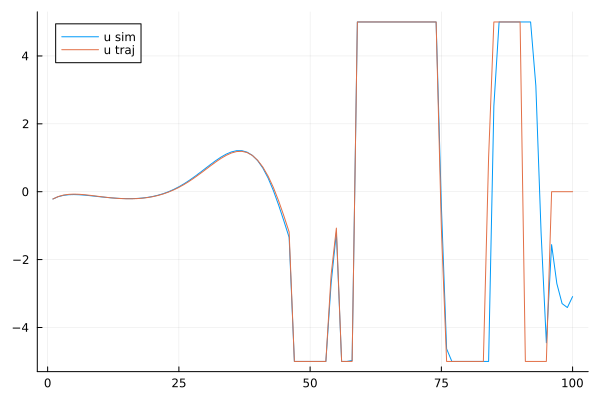

In [26]:
plot(utraj[1,:], label="u sim")
plot!(Uopt[:], label="u traj")

# ILC QP Logic

In [27]:
# QP params Setup
Qilc = sparse(Diagonal([0.01; 0; 1.0; 0]))
Rilc = sparse(Diagonal([.1]))

H = blockdiag(kron(I(N-2), blockdiag(Rilc, Qilc)), Rilc, sparse(Qf))
D = spzeros(n*(N-1), (m+n)*(N-1))
D[1:n,1:m] .= dB[:,:,1]
D[1:n,(m+1):(m+n)] .= -I(n)
for k in 1:(N-2)
    s1 = n*k .+ (1:n)
    s2 = m + (m+n)*(k-1) .+ (1:(2*n+m))
    D[s1,s2] .= [ dA[:,:,k+1] dB[:,:,k+1] -I(n) ]
end
U = kron(I(N-1), [ I zeros(m, n)]);

In [36]:
function qp_step(xtraj, utraj)
    q = zeros((m+n)*(N-1))
    for k in 1:(N-2)
        q[(m+n)*(k-1) .+ (1:(m+n))] .= [0.0; Qilc*(xtraj[:,k+1] - xnom[:,k+1])]
    end
    q[end-(m+n)+1:end] .= [0.0; sparse(Qf)*(xtraj[:,N] - xnom[:,N])]
    
    lb = zeros(n*(N-1)+(N-1))
    ub = zeros(n*(N-1)+(N-1))
    lb[end-(N-1)+1:end] .= -u_bnd .- utraj[1:end]
    ub[end-(N-1)+1:end] .= +u_bnd .- utraj[1:end]
    
    qp = OSQP.Model()
    OSQP.setup!(qp, P=H, q=q, A=[D; U], l=lb, u=ub, eps_abs=1e-6, eps_rel=1e-6, eps_prim_inf = 1.0e-6, eps_dual_inf = 1.0e-6, polish=1, verbose=false)
    results = OSQP.solve!(qp)
    ztraj = results.x;

    Δu = U*ztraj
    utraj[1:(N-1)] .= utraj[1:(N-1)] + Δu

    return utraj
end

function true_dynamics_rollout(utraj)
    xtraj = zeros(n,N)
    
    for k = 1:(N-1)
        # utraj[:,k] .= unom[:,k] - K[:,:,k]*(xtraj[:,k]-xnom[:,k]) #with LQR tracking controller
        # utraj[:,k] .= min.(u_bnd, max.(-u_bnd, utraj[:,k])) #clip values within torque limits
        xtraj[:,k+1] .= true_dynamics_rk4(xtraj[:,k], utraj[:,k])
    end

    return xtraj
end

true_dynamics_rollout (generic function with 1 method)

In [37]:
# real trajectory (real dynamics), initialize for initial guess
utraj = zeros(m, N-1)
utraj = zeros(m,N-1)
for k in 1:N
    xnom[:,k] .= Xopt[k]
    if k != N
        unom[:,k] .= Uopt[k]
        utraj[:,k] .= Uopt[k]
    end
end

# First Rollout
utraj = qp_step(xtraj, utraj)
xtraj = true_dynamics_rollout(utraj)
norm_r = norm(xtraj .- xnom)

iter = 0
while norm_r > 2.5
    utraj = qp_step(xtraj, utraj)
    xtraj = true_dynamics_rollout(utraj)
    
    iter += 1
    norm_r = norm(xtraj .- xnom)
    
    print("iter: $iter    |r|: $norm_r   \n")
end

print("iter: $iter    |r|: $norm_r   \n")

iter: 1    |r|: 8.74861800487701   
iter: 2    |r|: 4.730159800103163   
iter: 3    |r|: 2.944990098322816   
iter: 4    |r|: 2.772860733523449   
iter: 5    |r|: 2.8502109453736733   
iter: 6    |r|: 2.916522127934747   
iter: 7    |r|: 2.9434511266741707   
iter: 8    |r|: 2.9360575532972786   
iter: 9    |r|: 2.9084986242833515   
iter: 10    |r|: 2.8704238948017284   
iter: 11    |r|: 2.831098506426515   
iter: 12    |r|: 2.794800298402525   
iter: 13    |r|: 2.760457108683887   
iter: 14    |r|: 2.7299883616486924   
iter: 15    |r|: 2.705264442298395   
iter: 16    |r|: 2.6845293944609137   
iter: 17    |r|: 2.6664057244644352   
iter: 18    |r|: 2.650285055028665   
iter: 19    |r|: 2.635633010797144   
iter: 20    |r|: 2.6222178837798458   
iter: 21    |r|: 2.6099681279141906   
iter: 22    |r|: 2.5988776322730764   
iter: 23    |r|: 2.590495070593814   
iter: 24    |r|: 2.5835110717318384   
iter: 25    |r|: 2.577346032348395   
iter: 26    |r|: 2.571670482198132   
iter: 27  

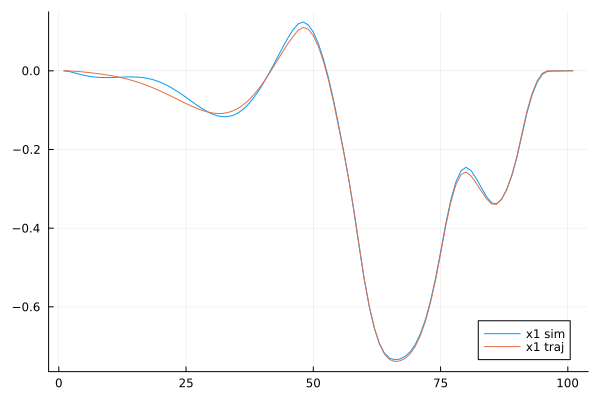

In [38]:
plot(xtraj[1,:], label="x1 sim")
plot!(xnom[1,:], label="x1 traj")

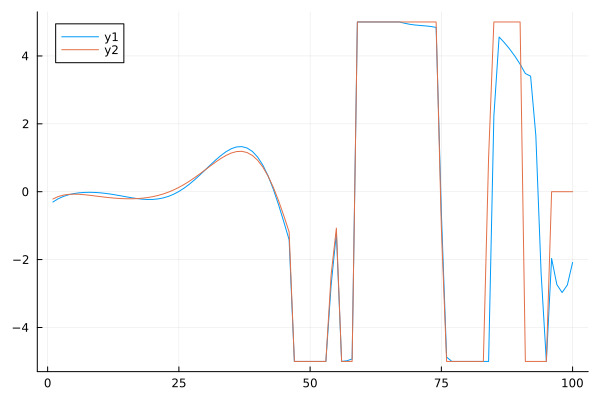

In [61]:
plot(utraj[1,:])
plot!(Uopt[:])

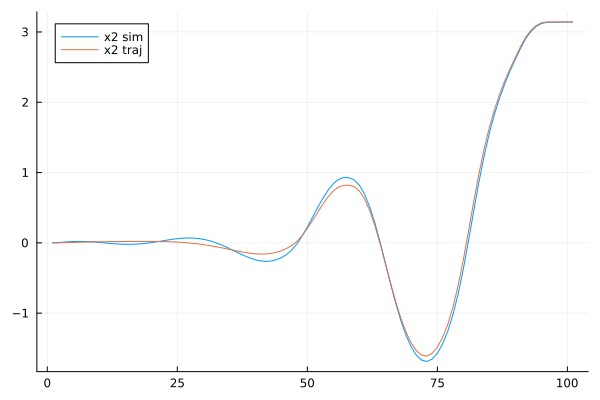

In [39]:
plot(xtraj[2,:], label="x2 sim")
plot!(xnom[2,:], label="x2 traj")

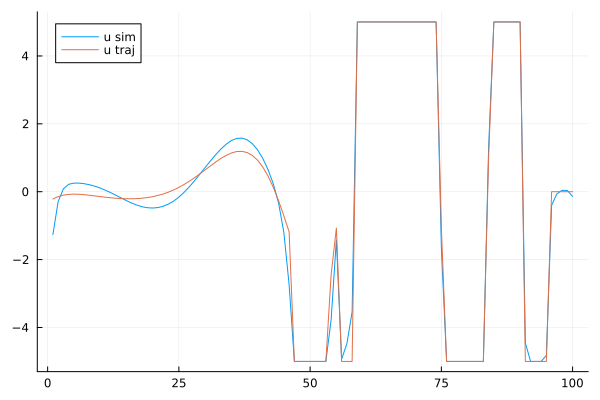

In [40]:
plot(utraj[1,:], label="u sim")
plot!(Uopt[:], label="u traj")

In [50]:
using JLD2

jldsave("cartpole_ilc.jld2"; xtraj=xtraj, utraj=utraj, xnom=xnom)